# Breakdown of the Heston model for stochastic volatility modeling

## Introduction to the Heston model

The Black-Scholes-Merton framework assume a constant volatility. That assumptions among others, does not reflect reality because in general, Volatility is neither constant nor deterministic - it is stochastic. One of the most popular models that fall into that category of models is the Heston stochastic volatility model.

The stochastic differential equations for the Heston stochastic volatility model are defined as follow:

$$
\begin{aligned}
& d X_t = r X_t dt + \sqrt{V_t} X_t dW_t\\ 
& d V_t = \kappa (\theta - V_t) dt + \lambda \sqrt{V_t} dB_t
\end{aligned}
$$
where 

* $W$ and $B$ are two correlated Weiner processes such that $d \langle W, B\rangle_t = \rho dt$ 
* $X_t$ is the index level at time $t$
* $V_t$ the stochastic volatility process

and the parameters are:

* $r$ is a constant risk-free rate 
* $\kappa$ is the mean reversion rate,
* $\theta$ is the long run variance,
* $\lambda$ is the volatility of the volatility,
* $V_0$ is the square of the initial volatility
* $\rho$ is the correlation coefficient.

## Close-form solutions to the Heston stochastic volatility model and its implementation

### The Close-form

The semi-analytical formula for a Heston call involves a complex integral :


$$\begin{aligned}  C=\frac{1}{2}\left(X_0-K e^{-r T}\right)+\frac{1}{\pi} \Re \int_0^{\infty}\left(e^{r T} \frac{\phi(u-\mathbf{i})}{\mathbf{i} u K^{\mathbf{i} u}}-K \frac{\phi(u)}{\mathbf{i} u K^{\mathbf{i} u}}\right) \mathrm{d} u \end{aligned}$$
With: 
* $\phi(u)=e^{r T} X_0^{\mathbf{i} u}\left(\frac{1-g e^{-d T}}{1-g}\right)^{-2 \frac{\theta \kappa}{\lambda^2}} \exp \left(\frac{\theta \kappa T}{\lambda^2}(\kappa-\rho \lambda \mathbf{i} u-d)+\frac{V_0}{\lambda^2}(\kappa-\rho \lambda \mathbf{i} u+d) \frac{1-e^{d T}}{1-g e^{d T}}\right), $
* $d=\sqrt{(\rho \lambda u \mathbf{i}-\kappa)^2+\lambda^2\left(\mathbf{i} u+u^2\right)}, $
* $g=\frac{\kappa-\rho \lambda \mathbf{i} u-d}{\kappa-\rho \lambda \mathbf{i} u+d} .$

The complex integral requires a careful discretization.

### The implementation of the solution

In [45]:
import numpy as np
from scipy.optimize import broyden1

In [48]:
# Initiale values
X0 = 100
V0 = 0.1
r = 0.05
K = 100
T = 2
kappa = 3.0
theta = 0.25
lambd = 0.1
rho = 0.6

In [47]:
def HestonModel(kappa, theta, lambd, T, K, X0, V0, rho, r):
    I = complex(0, 1) # define a imaginary unit
    integral, umax, N = 0, 1000, 10000 # initialize the call price C and set numerical integration limits
    du = umax/N # define the stepsize for numerical integration
    
    # Constants for characteristic function
    aa = theta * kappa * T / lambd**2
    bb = -2 * theta * kappa / lambd**2
    
    for i in range(1, N):
        u2 = i * du # define itegration variable u2
        u1 = complex(u2, -1) # define shifted integration variable u1
        
        # Compute a1 and a2 based on the model parameters
        a1, a2 = rho * lambd * u1 * I, rho * lambd * u2 * I
        
        # Compute characteristic function terms
        d1 = np.sqrt((a1 - kappa)**2 + lambd**2 * (u1 * I + u1**2))
        d2 = np.sqrt((a2 - kappa)**2 + lambd**2 * (u2 * I + u2**2))
        
        # Compute g functions
        
        ## Avoid division by zero and numerical overflows
        dg1, dg2 = kappa - a1 + d1, kappa - a2 + d2
        
        g1 = np.where(dg1!=0, (kappa - a1 - d1) / dg1, 0) ## If denominator is zero, set g1 to 0
        g2 = np.where(dg2!=0, (kappa - a2 - d2) / dg2, 0)
        
        # Compute the terms of the characteristic functions
        dt1 = np.exp(-d1 * T)
        denom1 = np.where((1 - g1)!=0, (1 - g1 * dt1) / (1 - g1), 1)
        term11 = np.exp(r * T + (u1 * I) * np.log(X0) + bb * np.log(denom1))
        dt1 = np.exp(-d1 * T)
        frac1 = np.where((1 - g1 * dt1)!=0, (1 - dt1) / (1 - g1 * dt1), 1)
        term21 = np.exp(aa * (kappa - a1 - d1) + (V0 / lambd**2) * (kappa -a1 + d1) * frac1)
        
        dt2 = np.exp(-d2 * T)
        denom2 = np.where((1 - g2)!=0, (1 - g2 * dt2) / (1 - g2), 1)
        term21 = np.exp(r * T + (u2 * I) * np.log(X0) + bb * np.log(denom2))
        dt2 = np.exp(-d2 * T)
        frac2 = np.where((1 - g2 * dt2)!=0, (1 - dt2) / (1 - g2 * dt2), 1)
        term22 = np.exp(aa * (kappa - a2 - d2) + (V0 / lambd**2) * (kappa -a2 + d2) * frac2)
        
        # Compute characteristic functions ph1 and phi2
        phi1 = term11 * term21
        phi2 = term21 * term22
        
        # Compute the integral
        d = u2*I * K**(u2*I)
        integral += (np.exp(r*T) * phi1 - K * phi2) * du / d
    
    # Compute the final value
    C = (X0 - K * np.exp(-r * T)) / 2 + np.real(integral) / np.pi
    
    return C     

In [49]:
# Example of usage of heston()
call = HestonModel(kappa, theta, lambd, T, K, X0, V0, rho, r)
print("call = ",call, " put = ", call-X0+K*np.exp(-r*T))

call =  5.3436242838786716e+53  put =  5.3436242838786716e+53


In [50]:
def HestonModel0(kappa, theta, lambd, T, K, X0, V0, rho, r):
    I = complex(0, 1)  # Define imaginary unit
    integral, umax, N = 0, 1000, 10000  # Initialize integral and set numerical integration limits
    du = umax / N  # Step size for numerical integration
    
    # Constants for characteristic function
    aa = theta * kappa * T / lambd**2
    bb = -2 * theta * kappa / lambd**2
    
    for i in range(1, N):
        u2 = i * du  # Define integration variable u2
        u1 = complex(u2, -1)  # Define shifted integration variable u1
        
        # Compute a1 and a2 based on model parameters
        a1, a2 = rho * lambd * u1 * I, rho * lambd * u2 * I
        
        # Compute characteristic function terms
        d1 = np.sqrt((a1 - kappa)**2 + lambd**2 * (u1 * I + u1**2))
        d2 = np.sqrt((a2 - kappa)**2 + lambd**2 * (u2 * I + u2**2))
        
        # Avoid division by zero and numerical overflows
        g1_denom = kappa - a1 + d1
        g2_denom = kappa - a2 + d2
        
        g1 = np.where(g1_denom != 0, (kappa - a1 - d1) / g1_denom, 0)  # If denominator is zero, set g1 to 0
        g2 = np.where(g2_denom != 0, (kappa - a2 - d2) / g2_denom, 0)
        
        # Compute exponential terms
        dt1 = np.exp(-d1 * T)
        dt2 = np.exp(-d2 * T)
        
        denom1 = np.where((1 - g1) != 0, (1 - g1 * dt1) / (1 - g1), 1)
        term11 = np.exp(r * T + (u1 * I) * np.log(X0) + bb * np.log(denom1))
        term21 = np.exp(aa * (kappa - a1 - d1) + (V0 / lambd**2) * (kappa - a1 + d1) * (1 - dt1) / (1 - g1 * dt1))
        
        denom2 = np.where((1 - g2) != 0, (1 - g2 * dt2) / (1 - g2), 1)
        term12 = np.exp(r * T + (u2 * I) * np.log(X0) + bb * np.log(denom2))
        term22 = np.exp(aa * (kappa - a2 - d2) + (V0 / lambd**2) * (kappa - a2 + d2) * (1 - dt2) / (1 - g2 * dt2))
        
        # Compute characteristic functions phi1 and phi2
        phi1 = term11 * term21
        phi2 = term12 * term22
        
        # Compute the integral
        d = u2 * I * K**(u2 * I)
        integral += (np.exp(r * T) * phi1 - K * phi2) * du / d
    
    # Compute the final value
    C = (X0 - K * np.exp(-r * T)) / 2 + np.real(integral) / np.pi
    
    return C


In [51]:
# Example of usage of heston()
call = HestonModel0(kappa, theta, lambd, T, K, X0, V0, rho, r)
print("call = ",call, " put = ", call-X0+K*np.exp(-r*T))

call =  3.527504374393724e+27  put =  3.527504374393724e+27


In [49]:
# example of calibration 
price1 = HestonModel0(kappa, theta, lambd, T, 90, X0, V0, rho, r)
price2 = HestonModel0(kappa, theta, lambd, T, 105, X0, V0, rho, r)
price3 = HestonModel0(kappa, theta, lambd, T, 110, X0, V0, rho, r)

def F(x):
    return [(price1 - HestonModel0(x[0],x[1],x[2],T,90, X0, V0, rho, r)), \
            (price2 - HestonModel0(x[0],x[1],x[2],T,105, X0, V0, rho, r)), \
            (price3 - HestonModel0(x[0],x[1],x[2],T,110, X0, V0, rho, r))]
x = broyden1(F, [1.4,0.03,0.5], f_tol=1e-14)
print("[kappa,theta,lambda] =",x)

C:\Users\asus\AppData\Local\Temp\ipykernel_14772\1623619327.py:48: RuntimeWarning: overflow encountered in scalar multiply
  integral += (np.exp(r * T) * phi1 - K * phi2) * du / d
C:\Users\asus\AppData\Local\Temp\ipykernel_14772\1623619327.py:48: RuntimeWarning: invalid value encountered in scalar multiply
  integral += (np.exp(r * T) * phi1 - K * phi2) * du / d
C:\Users\asus\AppData\Local\Temp\ipykernel_14772\1623619327.py:48: RuntimeWarning: overflow encountered in scalar subtract
  integral += (np.exp(r * T) * phi1 - K * phi2) * du / d
C:\Users\asus\AppData\Local\Temp\ipykernel_14772\1623619327.py:43: RuntimeWarning: overflow encountered in scalar multiply
  phi1 = term11 * term21
C:\Users\asus\AppData\Local\Temp\ipykernel_14772\1623619327.py:48: RuntimeWarning: invalid value encountered in scalar subtract
  integral += (np.exp(r * T) * phi1 - K * phi2) * du / d
C:\Users\asus\AppData\Local\Temp\ipykernel_14772\1623619327.py:43: RuntimeWarning: invalid value encountered in scalar mul

KeyboardInterrupt: 

In [52]:
def heston(kappa, theta, lambd, T, K, X0, V0, rho, r):
    I = complex(0, 1)  # Define imaginary unit
    P, umax, N = 0, 1000, 10000  # Initialize P and set numerical integration limits
    du = umax / N  # Step size for numerical integration
    
    # Constants for characteristic function
    aa = theta * kappa * T / lambd**2
    bb = -2 * theta * kappa / lambd**2
    
    for i in range(1, N):
        u2 = i * du  # Define integration variable u2
        u1 = complex(u2, -1)  # Define shifted integration variable u1
        
        # Compute a1 and a2 based on model parameters
        a1 = rho * lambd * u1 * I
        a2 = rho * lambd * u2 * I
        
        # Compute characteristic function terms
        d1 = np.sqrt((a1 - kappa)**2 + lambd**2 * (u1 * I + u1**2))
        d2 = np.sqrt((a2 - kappa)**2 + lambd**2 * (u2 * I + u2**2))
        
        # Avoid division by zero and numerical overflows
        g1_denom = kappa - a1 + d1
        g2_denom = kappa - a2 + d2
        g1 = np.where(g1_denom != 0, (kappa - a1 - d1) / g1_denom, 0)
        g2 = np.where(g2_denom != 0, (kappa - a2 - d2) / g2_denom, 0)
        
        # Compute exponential terms
        b1_exp = np.exp(-d1 * T)
        b2_exp = np.exp(-d2 * T)
        b1_denom = np.where(1 - g1 != 0, (1 - g1 * b1_exp) / (1 - g1), 1)
        b2_denom = np.where(1 - g2 != 0, (1 - g2 * b2_exp) / (1 - g2), 1)
        b1 = np.exp(u1 * I * (np.log(X0 / K) + r * T)) * b1_denom**bb
        b2 = np.exp(u2 * I * (np.log(X0 / K) + r * T)) * b2_denom**bb
        
        # Compute characteristic functions phi1 and phi2, avoiding overflow
        exp_term1 = np.exp(-d1 * T)
        exp_term2 = np.exp(-d2 * T)
        denom1 = np.where(1 - g1 * exp_term1 != 0, (1 - g1 * exp_term1), 1)
        denom2 = np.where(1 - g2 * exp_term2 != 0, (1 - g2 * exp_term2), 1)
        
        term1 = V0 * (kappa - a1 - d1) * (1 - exp_term1) / (denom1 * lambd**2)
        term2 = V0 * (kappa - a2 - d2) * (1 - exp_term2) / (denom2 * lambd**2)
        
        phi1 = b1 * np.exp(aa * (kappa - a1 - d1) + term1)
        phi2 = b2 * np.exp(aa * (kappa - a2 - d2) + term2)
        
        # Compute integral sum
        P += ((phi1 - phi2) / (u2 * I)) * du
    
    # Compute final option price
    return K * np.real((X0 / K - np.exp(-r * T)) / 2 + P / np.pi)

# Example usage (Ensure variables like X0, V0, rho, and r are defined before calling)


In [53]:
# Example of usage of heston()
call = heston(kappa, theta, lambd, T, K, X0, V0, rho, r)
print("call = ",call, " put = ", call-X0+K*np.exp(-r*T))

call =  31.9813378831051  put =  22.465079686701046


In [51]:
def F(x):
    return [(price1 - heston(x[0],x[1],x[2],T,90, X0, V0, rho, r)), \
            (price2 - heston(x[0],x[1],x[2],T,105, X0, V0, rho, r)), \
            (price3 - heston(x[0],x[1],x[2],T,110, X0, V0, rho, r))]
x = broyden1(F, [1.4,0.03,0.5], f_tol=1e-14)
print("[kappa,theta,lambda] =",x)

OverflowError: (34, 'Result too large')

## Numerical implementation of the Heston model

To account for the correlation between the two stochastic processes, one needs to determine the Cholesky decomposition of the correlation matrix. 

#### Cholesky decomposition of the correlation matrix

The correlation matrix $A$ and Cholesky decomposition resulting matrix $B$

In [54]:
A = np.zeros((2, 2))
A[0,:] = [1.0, rho]
A[1,:] = [rho, 1.0]

B = np.linalg.cholesky(A)

In [5]:
print(A)

[[1.  0.6]
 [0.6 1. ]]


In [6]:
print(B)

[[1.  0. ]
 [0.6 0.8]]


#### Simulation of the processes

Let defined the time step size by $\Delta t :=\dfrac{T}{M} $ where $M$ is the number of time intervals in the time discretization.

The volatility is modeled by the square-root diffusion. One can say that its dynamics follows a noncentral Chi-Squared distribution with:
$$ 
df = \dfrac{4 \theta \kappa}{\sigma^{2}}
$$
degree of freedom and noncentrality parameter
$$
nc = \dfrac{ 4 \kappa \exp{( - \kappa \Delta t)} }{ \sigma^{2} (1 - \exp{( - \kappa \Delta t)}) } V_{t - \Delta t}
$$

Two types of discretization are possible:

* The Euler discretization given by:

$z_t$ being a standard normally distributed random variable, one has:

$$
\begin{align}
& v_t = v_{t-\Delta t} + \kappa ( \theta - max(v_{t-\Delta t}, 0) ) \Delta t + \sqrt{max(v_{t-\Delta t}, 0)} \cdot \sqrt{\Delta t} z_t\\
& V_t = max(v_{t-\Delta t}, 0)
\end{align}
$$

* The exact discretization for the square-root diffusion corresponding to the stochastic volatility dynamics is:
$$
V_t = \dfrac{{ \sigma^{2} (1 - \exp{( - \kappa \Delta t)}) }}{4 \kappa} \Chi_{d}^{2} \left( \dfrac{4 \kappa \exp{( - \kappa \Delta t)}}{ \sigma^{2} (1 - \exp{( - \kappa \Delta t)}) } \right)
$$

We will use only the Euler discretization sheme because the sampling from the standard normal distribution is computationally less demanding than  from the noncentral Chi-square distribution..

In [16]:
import numpy.random as npr
import math

In [57]:
npr.seed(100)
M = 50  # Number of time intervals
I = 10000  # Number of paths to simulate
dt = T/M

norm_rand_num = npr.standard_normal((2, M+1, I)) # generate a three-dimensional random number data set

V = np.zeros_like(norm_rand_num[0]) # create an array of the same shape and type as norm_rand_num[0]
v = np.zeros_like(V)

V[0] = V0
v[0] = V0

for t in range(1, M+1):
    #Pick out the relevant random number subset and transform it via Cholesky matrix B
    rand_num = np.dot(B, norm_rand_num[:, t, :]) 
    # Simulation the paths uing Euler sheme
    v[t] = v[t-1] + kappa * (theta - np.maximum(v[t-1],0)) * dt + \
        lambd * np.sqrt(np.maximum(v[t-1],0)) * math.sqrt(dt) * rand_num[1]

V = np.maximum(v, 0)

We know that in the Black-Scholes framework, one has $\forall 0\leq s \leq t \leq T$:
$$
\begin{align}
& X_t = X_0 e^{(r - \frac{1}{2} \sigma^2  ) t + \sigma W_t} \\ 
& X_s = X_0 e^{(r - \frac{1}{2} \sigma^2  ) s + \sigma W_s}
\end{align}
$$
So that:
$$
X_t = X_s e^{(r - \frac{1}{2} \sigma^2  ) (t-s) + \sigma (W_t - W_s)}
$$

In the case of Heston model, $\sigma := \sqrt{V_t}$. Hence:

$$
X_t = X_s e^{(r - \frac{1}{2} V_t  ) (t-s) + \sqrt{V_t} (W_t - W_s)}
$$

The Euler exact discretization sheme corresponding to the previous expression is given by:
$$
X_{t} = X_{t-\Delta t} \exp{\left( (r - \dfrac{1}{2} V_t)) \Delta t + \sqrt{V_t} \sqrt{\Delta t} z_t \right)}
$$

The simulation of the index level takes into account the Cholesky decomposition

In [58]:
X = np.zeros_like(norm_rand_num[0])
X[0] = X0

for t in range(1, M+1):
    #Pick out the relevant random number subset and transform it via Cholesky matrix B
    rand_num = np.dot(B, norm_rand_num[:, t, :]) 
    # Simulation the paths uing Euler sheme
    X[t] = X[t-1] * np.exp((r - 0.5 * V[t])*dt + np.sqrt(V[t]) * np.sqrt(dt) * rand_num[0]) 


#### Visualization of the simulation results at maturity for both the processes

In [29]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Volatility')

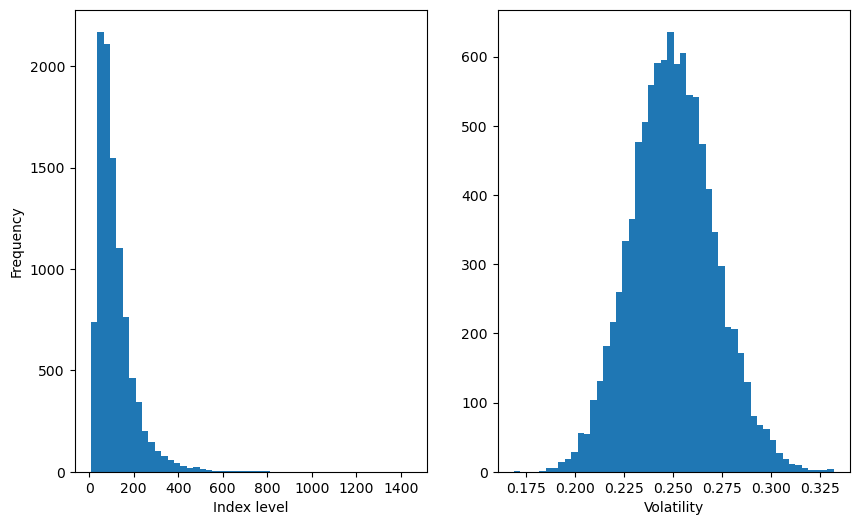

In [59]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.hist(X[-1], bins = 50)
ax1.set_xlabel('Index level')
ax1.set_ylabel('Frequency')
ax2.hist(V[-1], bins =50)
ax2.set_xlabel('Volatility')

In [60]:
import scipy.stats as scs

def print_statistics(a1, a2):

    stat1 = scs.describe(a1)
    stat2 = scs.describe(a2)

    print('%14s %14s %14s' %('statistics', 'data set 1', 'data set 2'))
    print('%14s %14.3f %14.3f' %('size', stat1[0], stat2[0]))
    print('%14s %14.3f %14.3f' %('min', stat1[1][0], stat2[1][0]))
    print('%14s %14.3f %14.3f' %('max', stat1[1][1], stat2[1][1]))
    print('%14s %14.3f %14.3f' %('size', stat1[2], stat2[2]))
    print('%14s %14.3f %14.3f' %('std', np.sqrt(stat1[3]), np.sqrt(stat2[3])))
    print('%14s %14.3f %14.3f' %('skew', stat1[4], stat2[4]))
    print('%14s %14.3f %14.3f' %('kurtosis', stat1[5], stat2[5]))

In [61]:
print_statistics(X[-1], V[-1])

    statistics     data set 1     data set 2
          size      10000.000      10000.000
           min          7.688          0.168
           max       1445.646          0.332
          size        116.637          0.250
           std         86.877          0.021
          skew          2.770          0.130
      kurtosis         15.656          0.021


Text(0, 0.5, 'volatility')

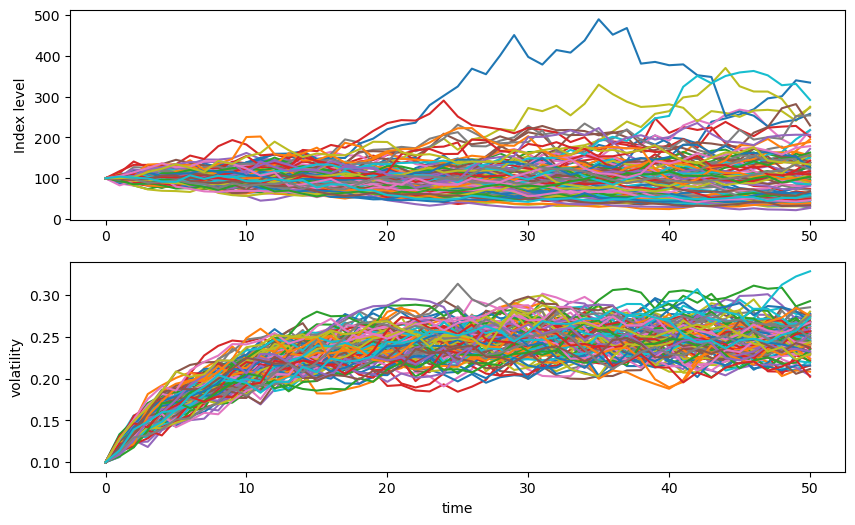

In [62]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
ax1.plot(X[:, :100], lw = 1.5)
ax1.set_ylabel('Index level')
ax2.plot(V[:, :100], lw = 1.5)
ax2.set_xlabel('time')
ax2.set_ylabel('volatility')

#### European Options prices under Heston framework

The price of an option of payoff $h(X_T)$ and strike $K$ written on the index which price is captured by $X_t$ at time $t$ is given:

$$ 
Price_0 = \dfrac{1}{I} \left( e^{-r T} \sum_{i = 1}^{I} h(X_T) \right)
$$

For European call and Put options, one has:

$$ 
\begin{aligned}
& C_0 = \dfrac{1}{I} \left( e^{-r T} \sum_{i = 1}^{I} max(X_T - K, 0) \right) \\
& P_0 = \dfrac{1}{I} \left( e^{-r T} \sum_{i = 1}^{I} max(K - X_T, 0) \right)
\end{aligned}
$$ 


In [63]:
C0 = math.exp(-r * T)* np.maximum(X[-1] - K, 0).mean()
P0 = math.exp(-r * T)* np.maximum(K - X[-1], 0).mean()

print(f'The Call option price is: { C0 }\nThe Put option price is: { P0}')

The Call option price is: 33.45548675952519
The Put option price is: 18.401860381399008
